Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


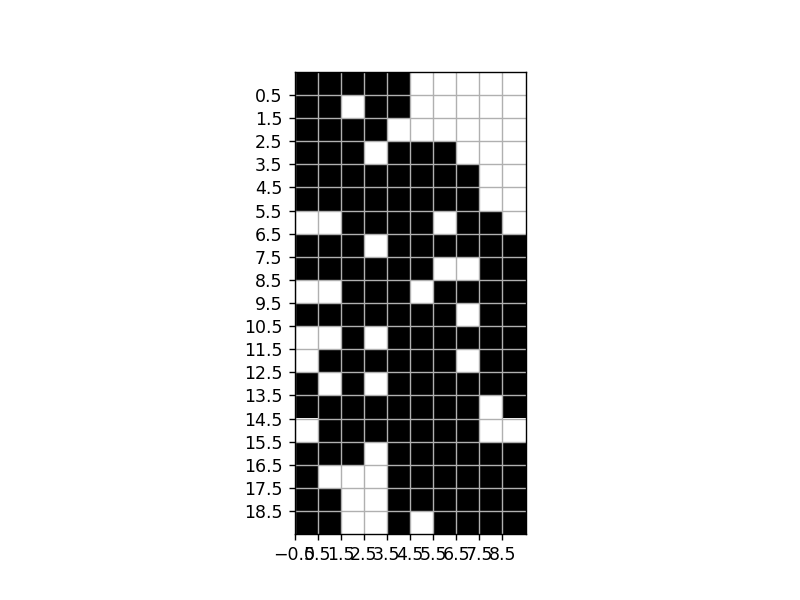

KeyboardInterrupt: 

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import copy
from collections import namedtuple, deque

%matplotlib notebook

# GPU if available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BOARD_WIDTH = 10
BOARD_HEIGHT = 20
BLANK = 0

TEMPLATE_WIDTH = 5
TEMPLATE_HEIGHT = 5

S_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '..OO.',
                     '.OO..',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..OO.',
                     '...O.',
                     '.....']]

Z_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '.OO..',
                     '..OO.',
                     '.....'],
                    ['.....',
                     '..O..',
                     '.OO..',
                     '.O...',
                     '.....']]

I_SHAPE_TEMPLATE = [['..O..',
                     '..O..',
                     '..O..',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     'OOOO.',
                     '.....',
                     '.....']]

O_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '.OO..',
                     '.OO..',
                     '.....']]

J_SHAPE_TEMPLATE = [['.....',
                     '.O...',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..OO.',
                     '..O..',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '...O.',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..O..',
                     '.OO..',
                     '.....']]

L_SHAPE_TEMPLATE = [['.....',
                     '...O.',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..O..',
                     '..OO.',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '.O...',
                     '.....'],
                    ['.....',
                     '.OO..',
                     '..O..',
                     '..O..',
                     '.....']]

T_SHAPE_TEMPLATE = [['.....',
                     '..O..',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..OO.',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '..O..',
                     '.....'],
                    ['.....',
                     '..O..',
                     '.OO..',
                     '..O..',
                     '.....']]

PIECES = {'S': S_SHAPE_TEMPLATE,
          'Z': Z_SHAPE_TEMPLATE,
          'J': J_SHAPE_TEMPLATE,
          'L': L_SHAPE_TEMPLATE,
          'I': I_SHAPE_TEMPLATE,
          'O': O_SHAPE_TEMPLATE,
          'T': T_SHAPE_TEMPLATE}

PIECES_IND = {'S': 0,
              'Z': 1,
              'J': 2,
              'L': 3,
              'I': 4,
              'O': 5,
              'T': 6}

PIECES_MARGINS = {'S': [[1, 1, 0], [0, 1, 1]],
                  'Z': [[1, 1, 0], [1, 0, 1]],
                  'J': [[1, 1, 1], [0, 1, 1], [1, 1, 0], [1, 0, 1]],
                  'L': [[1, 1, 1], [0, 1, 1], [1, 1, 0], [1, 0, 1]],
                  'I': [[0, 0, 2], [2, 1, 0]],
                  'O': [[1, 0, 0]],
                  'T': [[1, 1, 1], [0, 1, 1], [1, 1, 0], [1, 0, 1]]}


class Tetris:
    def __init__(self):
        self.board = self.getBlankBoard()
        self.current_piece = self.getNewPiece()

    def reset(self):
        """
        Restarts the game with a blank board and new piece.
        @rtype: torch tensor
            A tensor representing the state.
        """
        self.board = self.getBlankBoard()
        self.current_piece = self.getNewPiece()
        return self.convertToFeatures(self.board)[0]

    def isOnBoard(self, x, y):
        """
        Checks if the position (x,y) is on the board.
        @type x: int
            The x position
        @type y: int
            The y position

        @rtype: Boolean
            If (x,y) is on the board.

        """
        return 0 <= x < BOARD_WIDTH and 0 <= y < BOARD_HEIGHT

    def getBlankBoard(self):
        """
        Returns a blank board.
        """
        return np.zeros((BOARD_WIDTH, BOARD_HEIGHT))

    def isValidPosition(self, board, piece, x, y, rotation):
        """
        Checks if a piece has a valid position on the board.
        @type board: np.array
            A np array representing the state of the board.
        @type piece: string
            A string representing the shape of the piece.
        @type x: int
            The x position of the piece.
        @type y: int
            The y position of the piece.
        @rotation: int
            The rotation of the piece.
        @rtype: Boolean
            If the piece has a valid position on the board.

        """
        for dx in range(TEMPLATE_WIDTH):
            for dy in range(TEMPLATE_HEIGHT):
                template = PIECES[piece][rotation % len(PIECES[piece])]
                if template[dy][dx] == 'O':
                    board_x_pos, board_y_pos = x + (dx - 2), y - (dy - 2)
                    if not self.isOnBoard(board_x_pos, board_y_pos) or board[board_x_pos][board_y_pos]:
                        return False
        return True

    def getNewPiece(self):
        """
        Gets a new piece.
        @rtype: string
            A string representing the shape of the new piece.
        """
        return random.choice(list(PIECES.keys()))

    def findXYCoordinate(self, piece, action, board):
        """
        Find the x and y coordinates to place a piece given an action.
        @type piece: string
            A letter representing the shape of the piece to be placed.
        @type action: int
            An integer representing the action.
        @type board: np.array
            A np array representing the state of the board.
        @rtype: tuple[int]
            A tuple (x, y, rotation) representing the (x,y) coordinates of the
            piece if it were to be placed on the board as well as the rotation
            of the piece. Note that this does not actually place the piece.
        """
        rotation = action % 4
        left_margin, right_margin, top_margin = PIECES_MARGINS[piece][
            rotation % len(PIECES_MARGINS[piece])]
        x = max(left_margin, min(action // 4, BOARD_WIDTH - right_margin - 1))

        # Finding y coordinate to place the piece
        valid_y = None
        flag = False
        for y in range(BOARD_HEIGHT - top_margin - 1, -2, -1):
            if self.isValidPosition(board, piece, x, y, rotation):
                flag = True
            else:
                if flag:
                    valid_y = y + 1
                break

        return x, valid_y, rotation

    def transitionState(self, action):
        """
        Returns the next state given the action.
        @type action: int
            An integer representing the action chosen.
            In total, there are BOARD_WIDTH x 4 actions, representing
            choices in the x coordinate and rotation of the piece.
            For a chosen x and rotation r, the action is 4 * x + r.

        @rtype: tuple
            A tuple (reward, next_state, done) representing the reward, next state,
            and if the game has finished.

        """
        x, y, rotation = self.findXYCoordinate(self.current_piece, action, self.board)

        if y != None:
            #self.board, completed_lines = self.clearLines(self.board)

            self.board = self.placeOnBoard(self.current_piece, x, y, rotation, self.board)

            self.current_piece = self.getNewPiece()
            next_state, self.board, completed_lines = self.convertToFeatures(self.board)
            max_height, bumpiness = self.scoreBumpiness(self.board)
            #reward = lines_cleared**2 - delta_r - delta_c + 0.1
            reward = 0.2 + completed_lines * BOARD_WIDTH

            return reward, next_state, False, completed_lines

        return -1, self.convertToFeatures(self.board)[0], True, 0

    def getAllNextStates(self):
        """
        Get all of the next states corresponding to all possible next actions.
        @rtype: list[tuple]
            A list of tuples (action, features) representing the features of the
            next state if an action is taken.
        """
        data = []
        for action in range(BOARD_WIDTH * 4):
            temp_board = copy.deepcopy(self.board)
            x, y, rotation = self.findXYCoordinate(self.current_piece, action, temp_board)
            if y != None:
                board = self.placeOnBoard(self.current_piece, x, y, rotation, temp_board)
                features, board, _ = self.convertToFeatures(board)
                data.append((action, features))
        return data

    def removeFromBoard(self, piece, x, y, rotation, board):
        """
        removes the current piece on the board.
        @type piece: string
            A letter representing the shape of the piece.
        @type x: int
            The x position of the piece.
        @type y: int
            The y position of the piece.
        @type rotation: int
            The rotation of the piece.
        @type board: np.array
            A np array representing the board.
        @type: np.array
            A np array representing the board after the piece has been removed.
        """
        template = PIECES[piece][rotation % len(PIECES[piece])]
        for dx in range(TEMPLATE_WIDTH):
            for dy in range(TEMPLATE_HEIGHT):
                if template[dy][dx] == 'O':
                    board_x_pos, board_y_pos = x + (dx - 2), y - (dy - 2)
                    board[board_x_pos][board_y_pos] = 0.0

        return board

    def placeOnBoard(self, piece, x, y, rotation, board):
        """
        Places the current piece on the board. Assumes that the piece
        is in a valid position.
        @type piece: string
            A letter representing the shape of the piece.
        @type x: int
            The x position of the piece.
        @type y: int
            The y position of the piece.
        @type rotation: int
            The rotation of the piece.
        @type board: np.array
            A np array representing the board.
        @type: np.array
            A np array representing the board after the piece has been placed.
        """
        template = PIECES[piece][rotation % len(PIECES[piece])]
        for dx in range(TEMPLATE_WIDTH):
            for dy in range(TEMPLATE_HEIGHT):
                if template[dy][dx] == 'O':
                    board_x_pos, board_y_pos = x + (dx - 2), y - (dy - 2)
                    board[board_x_pos][board_y_pos] = 1.0

        return board

    def clearLines(self, board):
        """
        Removes completed lines from the board.
        @rtype: int
            The number of lines removed.

        """
        lines_removed = 0
        y = 0  # start y at the bottom of the board
        while y < BOARD_HEIGHT:
            if self.isCompleteLine(y, board):
                # Remove the line and pull boxes down by one line.
                for pull_down_Y in range(y, BOARD_HEIGHT - 1):
                    for x in range(BOARD_WIDTH):
                        board[x][pull_down_Y] = board[x][pull_down_Y + 1]
                # Set very top line to blank.
                for x in range(BOARD_WIDTH):
                    board[x][BOARD_HEIGHT - 1] = BLANK
                lines_removed += 1
                # Note on the next iteration of the loop, y is the same.
                # This is so that if the line that was pulled down is also
                # complete, it will be removed.
            else:
                y += 1  # move on to check next row up
        return board, lines_removed

    def countCompleteLines(self, board):
        """
        Counts the number of completed lines.
        @type board: np.array
            An np array representing the board.
        @rtype: int
            The number of completed lines on the board.
        """
        completed_lines = 0
        for y in range(BOARD_HEIGHT):
            if self.isCompleteLine(y, board):
                completed_lines += 1

        return completed_lines

    def isCompleteLine(self, y, board):
        """
        Checks if the line at height y is complete.
        @type y: int
            The height of the row to check.

        @rtype : Boolean
            True if the row is complete.

        """
        for x in range(BOARD_WIDTH):
            if board[x][y] == 0.0: return False
        return True

    def convertToFeatures(self, board):
        """
        Converts the current board position and falling piece to a
        list of features.
        The features consist of:
            - Number of holes along the vertical and horizontal directions.
            - Total height of all columns.
            - Bumpiness.
            - Number of completed lines on the board.
        @rtype: torch tensor
            Torch tensor of the features described above. Values normalized to be between -1 and 1.

        """
        board, completed_lines = self.clearLines(board)
        holes = self.countHoles(board)
        total_height, bumpiness = self.scoreBumpiness(board)

        return torch.tensor([[holes/BOARD_WIDTH,
                              total_height/BOARD_WIDTH,
                              bumpiness/BOARD_WIDTH, completed_lines*3]],
                            dtype=torch.float32).to(device), board, completed_lines

    def countHoles(self, board):
        """
        Counts the number of transitions from filled to empty or vice
        versa in the rows and columns.
        @rtype: tuple[int]
            A tuple (delta_r, delta_c) representing the number of transitions
            from filled to empty squares or vice versa across rows and columns respectively.

        """

        holes = 0
        for x in range(BOARD_WIDTH):
            loc = 0
            for y in range(BOARD_HEIGHT-1, -1, -1):
                if board[x][y] == 1.0:
                    loc = y
                    break
            for y in range(loc):
                if board[x][y] == 0.0:
                    holes += 1

        return holes

    def scoreBumpiness(self, board):
        """
        Calculates the "bumpiness" of the board, defined as the
        sum of the absolute differences in heights of adjacent columns,
        except for the largest difference.

        @type board: np.array
            A np array representing the board.
        @rtype: tuple[int]
            A tuple (max_height, bumpiness) representing the
            maximum height of any column and the bumpiness.
        """
        heights = []
        for x in range(BOARD_WIDTH):
            d = 0
            for y in range(BOARD_HEIGHT-1, -1, -1):
                if board[x][y]:
                    d = 1
                    break
            heights.append(y+d)


        diffs = [abs(heights[i]-heights[i-1]) for i in range(1, len(heights))]
        diffs.sort()

        return sum(heights), sum(diffs)-diffs[-1]


Transition = namedtuple('Transition', ('state', 'next_state', 'reward', 'done'))


class ReplayMemory:
    def __init__(self, capacity):
        """
        Initializes the replay memory.
        @type capacity: int
            The capacity of the memory.
        """
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Saves a transition.
        """
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """
        Samples a batch of transitions of size batch_size
        randomly.
        @type batch_size: int
            The size of the batch.
        @rtype: list[tuple]
            A list of the sampled transitions.
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class Agent:
    """ Agent object that uses the actor-critic network to find the
        optimal policy.
    """

    def __init__(self, env, NN, optimizer, criterion):
        """ Initializes the agent.

            @type env: Tetris
                The Tetris environment.
            @type NN: NeuralNet
                Neural network for computing the state-action values.
            @type optimizer: torch.optim
                Torch optimizer object.
            @type criterion: nn loss
                Neural network loss function.
            """
        self.env = env
        self.NN = NN
        self.optimizer = optimizer
        self.criterion = criterion

    def chooseAction(self, epsilon):
        """ Chooses action. With probability epsilon it will choose
            an exploratory action. Otherwise, it will choose
            an action which maximizes the estimated reward of all
            possible next states.

            @type epsilon: float
                Exploration probability.
            @rtype: int
                An integer representing the action.
        """
        if random.uniform(0, 1) < epsilon:
            return random.randrange(BOARD_WIDTH * 4)

        cur_best_val = -float('inf')
        cur_best_action = 0

        data = env.getAllNextStates()

        with torch.no_grad():
            for action, state in data:
                value = self.NN(state).item()
                if value > cur_best_val:
                    cur_best_val = value
                    cur_best_action = action

        return cur_best_action

    def optimizeModel(self, memory, batch_size, gamma):
        """
        Performs one step of mini-batch gradient descent.

        @type memory: ReplayMemory
            The replay memory from which to draw the experience.
        @type batch_size: int
            The mini-batch size.
        @type gamma: float
            The discount factor.
        """
        batch_size = min(len(memory), batch_size)

        # Sampling experiences
        transitions = memory.sample(batch_size)
        batch = Transition(*zip(*transitions))

        # Unpacking data
        state_batch = torch.cat(batch.state)
        next_state_batch = torch.cat(batch.next_state)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.cat(batch.done)

        # Predictions and targets
        predictions = self.NN(state_batch)
        with torch.no_grad():
            targets = reward_batch + gamma * self.NN(next_state_batch) * (~done_batch)

        # Loss and gradient descent
        loss = self.criterion(predictions, targets)

        loss.backward()

        self.optimizer.step()

        self.optimizer.zero_grad()

    def train(self, episodes, epsilon_initial, epsilon_min, epsilon_stop_episode,
              network_update_freq, gamma, memory_capacity, batch_size):
        """ Trains the agent using the actor-critic method with eligibility traces.

            @type episodes: int
                The number of episodes to train.
            @type epsilon: float
                The exploration probability.
            @type network_update_freq: int
                Number of episodes before copying the network
                parameters to the delayed network.
            @type gamma: float
                The discount factor.
            @type memory_capacity: int
                The capacity of the replay memory.
            @type batch_size: int
                Mini-batch size for training.

        """
        %matplotlib

        fig = plt.gcf()
        fig.show()
        fig.canvas.draw()
        plt.grid()
        plt.xlim(-0.5, BOARD_WIDTH - 0.5)
        plt.ylim(BOARD_HEIGHT - 0.5, -0.5)

        memory = ReplayMemory(memory_capacity)

        tot_steps = 0
        score = 0
        LC = 0

        depsilon = (epsilon_initial-epsilon_min)/epsilon_stop_episode

        for episode in range(episodes):

            if epsilon_initial > epsilon_min:
                epsilon_initial -= depsilon

            if (episode + 1) % 10 == 0:
                print(f'Episode {episode + 1}/{episodes} completed!')
                torch.save(self.NN.state_dict(), 'tetris_NN_value_model')
                print(f'Average steps per episode: {tot_steps / 10}')
                print(f'Average lines cleared per episode: {LC / 10}')
                print(f'Average reward per episode: {(score / 10):.2f}')
                score = 0
                tot_steps = 0
                LC = 0

            state, done = self.env.reset(), False

            # Initialize eligibility traces

            while not done:
                tot_steps += 1

                time.sleep(0.2)
                plt.imshow(np.transpose(self.env.board)[::-1], cmap=plt.cm.binary, interpolation='none', origin='lower')
                ax = plt.gca()
                ax.set_xticks(np.arange(-0.5, BOARD_WIDTH - 0.5, 1))
                ax.set_yticks(np.arange(0.5, BOARD_HEIGHT - 0.5, 1))
                fig.canvas.draw()

                action = self.chooseAction(epsilon_initial)

                reward, next_state, done, lines_cleared = self.env.transitionState(action)
                score += reward
                reward = torch.tensor([[reward]], device=device)
                done = torch.tensor([[done]], device=device)

                # Saves the transition
                memory.push(state, next_state, reward, done)

                LC += lines_cleared

                # Perform one step of batch gradient descent
                self.optimizeModel(memory, batch_size, gamma)

                state = next_state


class QNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(QNetwork, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, 1)

    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        x = self.l3(x)
        return x


if __name__ == "__main__":
    # Network parameters
    input_size = 4
    hidden_size1 = 32
    hidden_size2 = 16

    # Training parameters
    episodes = 1000000
    gamma = 0.95
    learning_rate = 1e-3
    epsilon_initial = 0.1
    epsilon_min = 0.1
    epsilon_stop_episode = 1500
    memory_capacity = 10000
    batch_size = 512
    network_update_freq = 100

    env = Tetris()
    model_value = QNetwork(input_size, hidden_size1, hidden_size2).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_value.parameters(), lr=learning_rate)

    model_value.load_state_dict(torch.load('tetris_NN_value_model'))

    tetris_agent = Agent(env, model_value, optimizer, criterion)

    tetris_agent.train(episodes, epsilon_initial, epsilon_min, epsilon_stop_episode,
              network_update_freq, gamma, memory_capacity, batch_size)